- 우선 Tensorflow API를 활용하기 위한 관련 패키지를 설치합니다.

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3592, done.
remote: Counting objects: 100% (3592/3592), done.
remote: Compressing objects: 100% (2999/2999), done.
remote: Total 3592 (delta 947), reused 1517 (delta 539), pack-reused 0
Receiving objects: 100% (3592/3592), 47.08 MiB | 19.60 MiB/s, done.
Resolving deltas: 100% (947/947), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .

In [ ]:
%%bash
cd models/research/
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1696518 sha256=7263cfd6d2343d3736d49f804f60e31608f617ddd08010d3933d454243ef426f
  Stored in directory: /tmp/pip-ephem-wheel-cache-b5q90p56/wheels/7d/96/c1/072a751379735e8dfdada1def1c62a89afb3cc45654fd6fd28
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=8d82daf22c0605baaecf3da79d5a502860322cc46ab3debdffd8f069bdb20849
  Stored in directory: /root/.cache/pip/wheels/07/35/78/e9004fa30578734db7f10e7a211605f3f0778d2bdde38a239d
  Created wheel for avro-python3: filename=avro_python3-1.10.2-py3-none-any.whl size=44009 sha256=293c5cf3f3f353867c02c1f5c76526f7d076084a3a8b2a857f214a1a0571ca72
  Stored in directory: /root/.cache/pip/wheels/bb/73/e9/d273421f5723c4bf544dcf9eb097bda94421ef8d3252699f0a
  Created wheel for docopt: filename=docopt-

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


- 성공적으로 Object Detection API가 설치되었다면, 실습을 위한 라이브러리를 import 합니다.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

- 아래 셀의 코드들은 모델 추론 과정 및 시각화에 사용되는 함수들을 정의한 것입니다. 자세한 내용은 코드의 주석을 참고해주세요.

In [ ]:
import tempfile
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

def run_inference_for_single_image(model, image, isFT=False):
  """
  model : 추론 단계에서 사용할 모델
  image : 추론 단계에서 모델의 입력으로 사용할 영상
  isFT : 모델의 미세조정 여부
  """

  image = np.asarray(image)
  
  # 모델의 입력 영상은 tensor type으로 변경해주어야만 합니다. 
  # 이는 'tf.convert_to_tensor'명령어를 통해 변경해줄 수 있습니다.
  if isFT:
    #finetuning한 모델의 경우 입력이 float32형 타입으로 들어오도록 코드가 작성되어있습니다.
    input_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    # 모델의 입력이 batch 단위로 들어오도록 기대됩니다.
    # 따라서 'tf.newaxis'명령어를 통해 영상의 차원을 하나 더 늘려줍니다. (e.g.) H, W, C --> B, H, W, C
    input_tensor = input_tensor[tf.newaxis,...]
    # 전처리된 영상을 모델에 넣어 추론을 시작합니다.
    output_dict = model.signatures['detect']((input_tensor))
  
  else:
    #위의 코드와 동일하게 tensor 타입으로 변경해주는 과정입니다.
    #다만 tensorflow에서 제공하는 pretrained model의 경우 uint8 타입의 영상을 입력으로 받습니다.
    input_tensor = tf.convert_to_tensor(image, dtype=tf.uint8)

    input_tensor = input_tensor[tf.newaxis,...]
    output_dict = model.signatures['serving_default']((input_tensor))

  # 모델의 추론 값들도 모두 배치 단위의 텐서로 출력됩니다.
  # 따라서 numpy array로 변형시킨 후 [0]에 대한 인덱싱을 통해 배치 차원을 제거해줍니다.
  # We're only interested in the first num_detections.

  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # 검출된 결과의 class는 int type이어야 합니다.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
  return output_dict

def show_inference(model, image_path, isFT=False):
  """
  model : 검출기,
  image_path : 추론에 활용할 영상의 경로
  isFT : 검출기의 미세조정 여부
  """

  # PIL Image 라이브러리를 통해 영상을 읽은 후 numpy type으로 변경해줍니다.
  image_np = np.array(Image.open(image_path))
  # run_inference_for_single_image 함수를 통해 영상 한장에 대한 검출이 수행됩니다.
  output_dict = run_inference_for_single_image(model, image_np, isFT=isFT)

  # 모델의 검출 결과를 정성적으로 시각화하는 과정입니다.
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np, #추론 때 활용한 영상
      output_dict['detection_boxes'], #검출 대상의 bounding box를 의미
      output_dict['detection_classes'] + 1, #검출 대상의 class를 의미
      output_dict['detection_scores'], #검출된 대상의 confidence score를 의미(즉 대상이 어떠한 class인지에 대한 확신도)
      category_index, # 모델의 class number와 매칭되는 카테고리 사전
      instance_masks=output_dict.get('detection_masks_reframed', None), #?
      use_normalized_coordinates=True,#box의 좌표계가 정규화가 되었는지 여부 (e.g., 640x512는 절대좌표, 0~1 사이 값은 정규좌표)
      line_thickness=8, #시각화 할 때의 박스 테두리 굵기
      min_score_thresh=0.30 # confidence score의 정도에 따른 검출 시각화 여부 임계치
  )

  display(Image.fromarray(image_np))

def download_and_resize_image(url, new_width=640, new_height=640,
                              display=False):
  """
  url : 이미지가 저장된 URL
  new_width : resize 함수에 사용할 목표 너비 해상도
  new_height : resize 함수에 사용할 목표 높이 해상도
  display : 다운받은 영상의 시각화 여부
  """
  """
  해당 함수는 외부 사이트에 저장된 이미지들의 URL을 읽어
  모델 추론에 입력으로 활용하는 이미지 로더입니다.
  """

  _, filename = tempfile.mkstemp(suffix=".jpg")

  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)

  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)

  print("Image downloaded to %s." % filename)

  if display:
    display_image(pil_image)

  return filename

- 먼저 TensorFlow에서 제공하는 Object Detection(TF-OD) API에 대한 간단한 실습을 진행해봅시다.

- TF-OD API에서 제공하는 검출기 모델 중 이번 실습에서는 MobilenetV2 모델을 백본으로 활용한 SSD 검출기를 활용합니다.
(이번 프로젝트에서는 나노 보드의 메모리 한계로 인하여 상대적으로 가벼운 SSD_mobilenetV2_fpnlite 모델을 활용하는 것을 적극 권장합니다.)

- 아래 셀을 통해 체크포인트와 모델의 관련 정보들을 읽어옵니다.

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/
# Tensorflow Object Detection API에서 제공하는 MS COCO pretrained SSD의 체크포인트를 다운받습니다.
# !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
# tar 명령어로 압축을 해제합니다.
!tar -xf ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz

# 사전학습된 모델의 정보가 담겨있는 config 파일을 읽어옵니다.
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)

# MS COCO dataset의 80가지 category 정보를 읽어옵니다.
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap("/content/models/research/object_detection/data/mscoco_label_map.pbtxt")
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

--2022-12-11 13:35:26--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.119.128, 2a00:1450:4013:c00::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.119.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20518283 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.57M  67.2MB/s    in 0.3s    

2022-12-11 13:35:27 (67.2 MB/s) - ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’ saved [20518283/20518283]



### 사전학습된 모델을 load하여 더미 입력을 넣어보면 8가지의 결과값들이 출력으로 나옵니다.
1. "detection_multiclass_scores"
2. "detection_scores"
3. "num_detections"
4. "detection_anchor_indices"
5. "raw_detection_scores"
6. "detection_classes"
7. "raw_detection_boxes"
8. "detection_boxes"

- 여기서 추론에 중요한 값들은 2,3,6,8로 각각 검출된 대상의 confidence score, 검출된 박스의 개수, 검출된 대상의 class 종류, 그리고 검출된 대상의 bounding box 좌표를 각각 의미합니다. (참고로 앞에 "raw_"가 붙은 결과 값들은 모두 Non-Maximum Suprression(NMS) 처리가 진행되지 않은 결과 값을 의미합니다.)

각 결과값에 대한 조금 더 구체적인 정보는 (https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1) 참조

In [ ]:
# 사전 학습된 모델을 load 합니다.
new_model = tf.saved_model.load('/content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/saved_model')

# 사전 학습된 모델이 잘 동작하는지를 확인하기 위해 더미 영상을 입력으로 집어넣습니다.
try:
  detections= new_model.signatures[ 'serving_default' ](tf.convert_to_tensor(np.ones([1,640,640,3]), dtype=tf.uint8))
  detections.keys()
except:
  print("Fail to load model")

- 아래 셀을 실행시키면 한 장의 이미지에 대한 모델의 검출 결과가 정성적으로 나타납니다.

Image downloaded to /tmp/tmpjvpbwt1b.jpg.


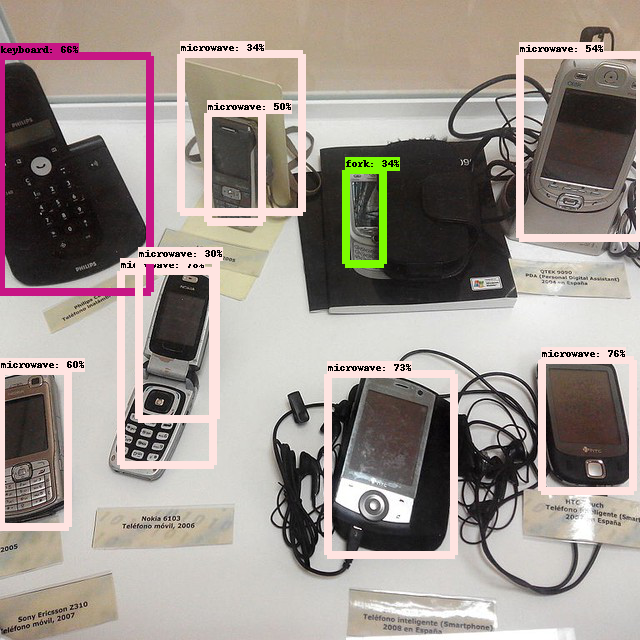

In [ ]:
import time

image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  ]

def detect_img(image_url):
  
  image_path = download_and_resize_image(image_url, 640, 640)
  start_time = time.time()
  show_inference(new_model, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)

#url을 통해 인터넷 속 영상을 읽어와서 검출 결과를 정성적으로 확인해봅시다.
detect_img(image_urls[1])

## Fine Tuning
- 그러면 MS-COCO로 사전학습된 검출기를 활용해 나만의 검출기로 Fine-tuning하는 과정에 대해서 다루어봅시다.

- 먼저 위의 실습과 동일하게 이미지 로더 및 시각화와 관련된 함수를 아래 셀에서 정의합니다.

In [ ]:
def load_image_into_numpy_array(path):
  """이미지 경로를 받아 영상을 numpy array 타입으로
  변환시켜서 반환하는 함수입니다.

  Args:
    path: 이미지 파일의 경로

  Returns:
    uint8 타입의 numpy array 영상 (img_height, img_width, 3)
  """

  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  image = image.resize([640, 640])
  (im_width, im_height) = image.size

  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """검출 결과를 시각화 하기 위한 함수입니다.

  Args:
    image_np: uint8 타입의 numpy array 영상 shape : (img_height, img_width, 3)

    boxes: numpy array 타입의 바운딩 박스 좌표 shape [N, 4]

    classes: numpy array 타입의 검출 클래스 값 shape [N]. 참고로 해당 값은 argmax를
    통한 가장 높은 확률의 클래스를 가지고 있어야만 label map과 매칭이 가능합니다.

    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.

    category_index: 모델이 예측 가능한 카테고리 정보가 담긴 딕셔너리.

    figsize: 영상의 크기

    image_name: 이미지 파일의 이름
  """
  image_np_with_annotations = image_np.copy()

  #visualize_boxes_and_labels_on_image_array 라는 TF-OD에서 제공하는 함수를 통해
  #검출된 결과를 시각화 합니다.
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,#검출 대상의 bounding box를 의미
      classes,#검출 대상의 class를 의미
      scores,#검출된 대상의 confidence score를 의미(즉 대상이 어떠한 class인지에 대한 확신도)
      category_index,# 모델의 class number와 매칭되는 카테고리 사전
      use_normalized_coordinates=True,#box의 좌표계가 정규화가 되었는지 여부 (e.g., 640x512는 절대좌표, 0~1 사이 값은 정규좌표)
      min_score_thresh=0.50)# confidence score의 정도에 따른 검출 시각화 여부 임계치

  #정성적 결과를 어디에 저장할지 경로가 제공될 경우, 해당 경로에 저장합니다.  
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)
  
  return image_np_with_annotations #정성적 결과영상을 반환합니다.

Inference time: 0.39995527267456055


### Annotation

- 검출기를 학습시키기 위해서는 물체에 대한 bounding box 정보가 필요합니다.

- Single class에 대해서만 annotation을 할 수 있는 TF-OD APIannotation 함수 대신, multiple class에 대해서 annotation을 수행할 수 있는 "LabelImg" 툴을 활용할 것입니다.

- LabelImg 툴은 로컬 피시에서 프로그램을 실행시켜서 수행이 가능하며, 코랩에서는 LabelImg 툴을 통해 annotation이 다 되었다는 가정하에 학습 영상 + annotation box 파일을 읽어와서 학습에 활용할 수 있도록 전처리 과정을 수행합니다.

- LabelImg의 사용법은 해당 링크를 통해서 확인해주세요.

In [ ]:
# gdown 명령어를 통해 구글 드라이브에 있는 파일을 읽어올 수 있습니다.
# tar 명령어를 통해 tar 압축 파일 해제
# 해당 tar 파일에는 train image 뿐만 아니라, annotation 정보가 들어있는 xml 파일이 함께 존재해야만 합니다.
#ttps://drive.google.com/file/d/1s1AkBQYdZ0VG-dIkr5tRF-zRbdYbImVx/view?usp=sharing
#https://drive.google.com/file/d/1Lx-AuN9Ad-SuZkgZpBHJEQL5jiYywZDI/view?usp=sharing
#https://drive.google.com/file/d/1yBbdFm5F_rVMPTVG0cwd3FE4JxIxvX6z/view?usp=share_link
#https://drive.google.com/file/d/1jILjuf_mCe2y5eMcs6FB6b3sdxAzQiue/view?usp=share_link
#https://drive.google.com/file/d/1v5scHOupqigAHjQivvIoZBB_MtiW9sgt/view?usp=share_link
!gdown https://drive.google.com/uc?id=1v5scHOupqigAHjQivvIoZBB_MtiW9sgt&export=download
!tar -xvf ./multiple_object_detection.tar

Downloading...
From: https://drive.google.com/uc?id=1v5scHOupqigAHjQivvIoZBB_MtiW9sgt
To: /content/multiple_object_detection.tar
100% 13.2M/13.2M [00:00<00:00, 21.0MB/s]
multiple_object_detection/
multiple_object_detection/test_data/
multiple_object_detection/train_data/
multiple_object_detection/test_data/01.jpg
multiple_object_detection/test_data/02.jpg
multiple_object_detection/test_data/03.jpg
multiple_object_detection/test_data/04.jpg
multiple_object_detection/test_data/05.jpg
multiple_object_detection/test_data/06.jpg
multiple_object_detection/train_data/01.mp4_20221206_201237.468.jpg
multiple_object_detection/train_data/01.mp4_20221206_201237.468.xml
multiple_object_detection/train_data/01.mp4_20221206_201241.997.jpg
multiple_object_detection/train_data/01.mp4_20221206_201241.997.xml
multiple_object_detection/train_data/01.mp4_20221206_201245.268.jpg
multiple_object_detection/train_data/01.mp4_20221206_201245.268.xml
multiple_object_detection/train_data/01.mp4_20221206_201248.80

In [ ]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

def xml_to_csv(path):
  '''
  LabelImg 툴을 활용하게 되면 영상 한장 당 해당 영상에 대응되는 annotation 정보를
  xml 파일 형식으로 저장하게 됩니다. 따라서 우리는 xml 파일을 모두 읽어와
  하나에 csv 파일 형식으로 묶는 과정을 해당 함수를 통해 수행합니다.
  '''
  xml_list = []

  for xml_file in glob.glob(path+'/*.xml'):
      tree = ET.parse(xml_file)
      root = tree.getroot()
      
      for member in root.findall('object'):
        value = (root.find('filename').text,
                 int(root.find('size')[0].text),
                 int(root.find('size')[1].text),
                 member[0].text,
                 int(member[4][0].text),
                 int(member[4][1].text),
                 int(member[4][2].text),
                 int(member[4][3].text)
                 )
        xml_list.append(value)

  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name)
    
  return xml_df

In [ ]:
#학습 데이터의 경로를 지정해준 후 해당 경로 안에 있는 xml 파일들을 하나의 csv 파일로 변환해줍니다.
image_path = os.path.join('multiple_object_detection','train_data')
xml_df = xml_to_csv(image_path)
xml_df.to_csv(('_labels.csv'), index=None)

print('Successfully converted xml to csv.')

Successfully converted xml to csv.


- **xml_to_csv 함수를 통해 생성된 csv 파일은 크게 아래 항목의 값들을 가지고 있습니다.**



1.   filename : 영상 이름
2.   width : 영상의 너비
3.   height : 영상의 높이
4.   class : 해당 bounding box의 class label
5.   xmin : bounding box의 좌상단 x 좌표
6.   ymin : bounding box의 좌상단 y 좌표
7.   xmax : bounding box의 우하단 x 좌표
8.   ymax : bounding box의 우하단 y 좌표



In [ ]:
xml_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,04.mp4_20221206_211159.900.jpg,1280,720,Not Enough,612,258,713,380
1,04.mp4_20221206_211209.566.jpg,1280,720,Not Enough,635,462,758,598
2,03.mp4_20221206_201653.162.jpg,1280,720,Not Enough,628,219,797,397
3,04.mp4_20221206_211322.286.jpg,1280,720,Not Enough,363,304,467,416
4,01.mp4_20221206_201256.560.jpg,1280,720,Enough,543,169,720,362
...,...,...,...,...,...,...,...,...
87,02.mp4_20221206_201432.049.jpg,1280,720,Enough,407,166,716,481
88,01.mp4_20221206_201237.468.jpg,1280,720,Enough,674,291,831,447
89,03.mp4_20221206_201630.192.jpg,1280,720,Not Enough,403,360,629,583
90,04.mp4_20221206_211148.630.jpg,1280,720,Not Enough,478,298,578,407


In [ ]:
# 아래 함수는 텍스트로 적혀있는 class를 int로 변환해주는
# Label Encoder 기능을 수행하는 함수입니다.
# 본인의 검출기의 class에 맞추어 아래 함수를 수정해주시면 됩니다.
def class_text_to_int(row_label):
    if row_label == 'Enough':
        return 1
    elif row_label == 'Not Enough':
        return 2
    # elif row_label == 'extra_class1':
    #     return 3
    # elif row_label == 'extra_class2':
    #     return 4
    # elif row_label == 'extra_class3':
    #     return 5
    else:
        None

- XML 파일을 CSV 파일로 변환하여 학습 데이터에 대한 annotation 정보를 전처리 하였다면, 아래 코드를 실행시킴으로써 학습 이미지, 정답 바운딩 박스, 정답 클래스 라벨을 쭉 읽어옵니다.

In [ ]:
train_image_dir = os.path.join('multiple_object_detection','train_data')
train_images_np = []

gt_boxes = []
intra_boxes = []

gt_classes = []
intra_classes = []

prev_id = None
for j, row in xml_df.iterrows():

  # 해당 바운딩 박스의 class label은 문자열로 되어있기에 위에서 정의한
  # 함수를 통하여 text를 int형 label로 변경해줍니다.
  class_id = class_text_to_int(row['class'])
  id = row["filename"]#해당 바운딩 박스가 존재하는 영상의 이름.

  # # csv 파일의 첫 행을 읽어올 때 조건문입니다.
  # if prev_id is None:
  #   prev_id = id
  #   #아래 코드를 통해 영상을 읽어옵니다.
  #   image_path = os.path.join(train_image_dir, row['filename'])
  #   train_images_np.append(load_image_into_numpy_array(image_path))

  #다른 영상으로 넘어가는 경우
  if prev_id is not id:
    #영상을 읽어옵니다.
    image_path = os.path.join(train_image_dir, row['filename'])
    train_images_np.append(load_image_into_numpy_array(image_path))

    #이전 영상 내의 바운딩 박스들 좌표와 class label들을 저장합니다.
    if prev_id is not None:
      gt_boxes.append(np.array(intra_boxes))
      gt_classes.append(np.array(intra_classes))
    
    del intra_boxes, intra_classes

    prev_id = id

    intra_boxes = []
    intra_classes = []

  #TensorFlow Ojbect Detection API는 모델 학습 때 GT bounding box가
  # (y_min, x_min), (y_max, x_max) 순서로 들어옵니다.
  # 또한 저희가 LabelImg로 annotation한 값은 절대좌표(i.e., 입력 영상의 해상도)
  # 로 되어있기에 입력 영상의 해상도로 나눔으로써 정규(상대)좌표 값으로 변경을 해줍니다.
  array = np.array([float(row["ymin"]) / float(row["height"]), float(row["xmin"]) / float(row["width"]),
                    float(row["ymax"]) / float(row["height"]), float(row["xmax"]) / float(row["width"])], dtype=np.float32)

  classes = class_id
  
  intra_boxes.append(array)
  intra_classes.append(classes)

#마지막 iteration에 대한 결과값을 반영해주기 위해 한번 더 append를 수행해줍니다.
gt_boxes.append(np.array(intra_boxes))
gt_classes.append(np.array(intra_classes))

print(gt_boxes, gt_classes)

[array([[0.35833332, 0.478125  , 0.5277778 , 0.5570313 ]], dtype=float32), array([[0.64166665, 0.49609375, 0.83055556, 0.5921875 ]], dtype=float32), array([[0.30416667, 0.490625  , 0.55138886, 0.6226562 ]], dtype=float32), array([[0.42222223, 0.28359374, 0.5777778 , 0.36484376]], dtype=float32), array([[0.23472223, 0.42421874, 0.50277776, 0.5625    ]], dtype=float32), array([[0.5861111 , 0.3734375 , 0.71944445, 0.42890626]], dtype=float32), array([[0.29166666, 0.325     , 0.4513889 , 0.3953125 ]], dtype=float32), array([[0.49444443, 0.30859375, 0.65      , 0.38671875]], dtype=float32), array([[0.3875    , 0.37109375, 0.62083334, 0.50390625]], dtype=float32), array([[0.4486111 , 0.37890625, 0.69166666, 0.5179688 ]], dtype=float32), array([[0.48472223, 0.24375   , 0.6486111 , 0.33125   ]], dtype=float32), array([[0.23194444, 0.51484376, 0.3861111 , 0.5796875 ]], dtype=float32), array([[0.62222224, 0.3921875 , 0.75416666, 0.459375  ]], dtype=float32), array([[0.5347222 , 0.42109376, 0.705

In [ ]:
# 각 class 별 id 값을 설정해줍니다.
# 해당 값은 저희가 annotation 하여 text2int로 변경해준 class id와
# 동일한 값으로 설정해주어야만 합니다.
pet_class_id = 1
aluminum_can_class_id = 2

# label id offset은 항상 1로 고정해줍니다.
label_id_offset = 1

#전체 class의 개수를 의미하며 본인의 학습 class 수에 맞추어 설정해줍니다.
num_classes = 2 

# category_index는 아래와 같이 2중 딕셔너리 타입으로 구성되어 있습니다.
# 본인의 class 개수에 맞게 아래 카테고리 인덱스를 수정해줍니다.
category_index = {pet_class_id: {'id': pet_class_id, 'name': 'Enough'},
                  aluminum_can_class_id : {'id': aluminum_can_class_id, 'name' : 'Not Enough'}}


# 아래 코드들은 numpy 형식의 train image, gt_box, gt_class에 대하여 
# 모델 학습을 위한 전처리 과정입니다. 이전 실습과 대부분 동일하게 작성되어 있습니다.
train_image_tensors = []
gt_box_tensors = []
gt_classes_one_hot_tensors = []

for (train_image_np, gt_box_np, gt_cls_np) in zip(train_images_np, gt_boxes, gt_classes):
  # 학습에 사용할 영상을 tensor 타입으로 변경 및 batch dimension을 추가합니다.
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  # GT로 활용할 bounding box 좌표 역시 tensor 및 batch dimension을 추가합니다.
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))

  # 이전 실습에서는 class가 1개 였기에 np.ones만을 활용하였지만, multi class의
  # 경우에는 np.ones 배열에 해당 class의 id를 곱해줌으로써 각 class별로 올바른
  # id가 가지도록 해줍니다.
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) * gt_cls_np - label_id_offset)

  # class에 대한 one-hot encoding 과정을 수행합니다.
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config'
checkpoint_path = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0'

# MS-COCO dataset으로 사전 학습한 검출기는 총 90개의 class를 예측하고 있기 때문에,
# 우리는 미세 조정 때 정의한 clas의 개수 'num_classes'의 값으로 덮어씌웁니다.
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True

# 위의 수정한 정보들을 토대로 SSD 검출기를 구축합니다.
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# MS-COCO의 체크포인트를 빌드한 모델에 적용하는 단계입니다.
# 먼저 SSD에는 크게 2개의 head가 존재하는데 하나는 classification head, 
# 다른 하나는 box regression head로 구성이 됩니다. 저희는 여기서 box regression
# head는 사전 학습된 weight를 그대로 활용하며, classification head만은 처음부터
# 새롭게 학습시킬 것입니다.
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    # 위에 주석처리한 라인이 classification head의 weight를 불러오는 명령어입니다.
    # 주석을 제거할 경우 classification head에 대한 weight를 함께 읽어옵니다.
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          # _prediction_heads=detection_model._box_predictor._prediction_heads,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
# restore 명령어를 통해 사전 학습된 weight를 모델에 load 합니다.
ckpt.restore(checkpoint_path).expect_partial()

# 빌드된 모델이 정상적으로 동작하는지를 확인하기 위해 더미 입력을 넣습니다.
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
tmp = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


### Model Training

- Annotation한 정보와 build한 모델을 가지고 전이 학습을 수행해봅시다.

In [ ]:
tf.keras.backend.set_learning_phase(True)

# 모델 학습에 사용할 하이퍼 파라미터 모음입니다.
batch_size = 4
learning_rate = 2e-2
num_batches = 3000

# 미세 조정을 적용할 레이어를 조정하는 코드입니다.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']

for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: tf.float32 타입을 가지는 [1, height, width, 3] Tensor들의 리스트
        다양한 해상도의 영상이 입력으로 들어와도 640, 640으로 resize 됩니다.

      groundtruth_boxes_list: 영상과 매칭되는 GT bounding box 좌표 리스트

      groundtruth_classes_list: bounding box의 class 리스트

    Returns:
      입력 배치에 대한 평균 total loss
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)

    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    
    with tf.GradientTape() as tape:

      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)

      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))

    return total_loss

  return train_step_fn

#모델 학습에 사용할 optimize는 SGD_momentum 입니다.
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)

for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # 해당 실습에서는 딱히 어떠한 data augmentation 기법을 적용하지 않습니다.
  # 만약 모델 학습 시에 데이터 증강 기법을 적용해야할 것 같다면, TF에서는
  # Random Horizontal flipping과 Random Cropping을 권장합니다.
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]

  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 50 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)
print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)
print('Done fine-tuning!')

Start fine-tuning!


/usr/local/lib/python3.8/dist-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


batch 0 of 3000, loss=1.3940926
batch 50 of 3000, loss=0.65867937
batch 100 of 3000, loss=0.40897372
batch 150 of 3000, loss=0.5468867
batch 200 of 3000, loss=0.34028575
batch 250 of 3000, loss=0.29055646
batch 300 of 3000, loss=0.36852735
batch 350 of 3000, loss=0.3093224
batch 400 of 3000, loss=0.2956962
batch 450 of 3000, loss=0.22161552
batch 500 of 3000, loss=0.15469515
batch 550 of 3000, loss=0.22913451
batch 600 of 3000, loss=0.1849623
batch 650 of 3000, loss=0.25366136
batch 700 of 3000, loss=0.20089199
batch 750 of 3000, loss=0.31188637
batch 800 of 3000, loss=0.14693153
batch 850 of 3000, loss=0.22713868
batch 900 of 3000, loss=0.18606621
batch 950 of 3000, loss=0.3384322
batch 1000 of 3000, loss=0.16640303
batch 1050 of 3000, loss=0.18386447
batch 1100 of 3000, loss=0.21218106
batch 1150 of 3000, loss=0.15320908
batch 1200 of 3000, loss=0.20838976
batch 1250 of 3000, loss=0.21566077
batch 1300 of 3000, loss=0.21404381
batch 1350 of 3000, loss=0.15606008
batch 1400 of 3000, l

### Inference

- 모델 학습이 다 완료되었다면 이제 학습된 모델을 통해 추론을 해봅시다.

In [ ]:
# 추론 코드
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: input_tensor: tf.float32 타입의 영상 텐서.

  Returns:
    다음 3가지 텐서 (`detection_boxes`, `detection_classes`,
      and `detection_scores`) 가 담겨있는 딕셔너리
  """
  #preprocess 함수를 통해 입력 영상을 모델 입력에 맞게 resize 합니다.
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  #추론
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  
  return detection_model.postprocess(prediction_dict, shapes)

#category_index는 아래와 같이 2중 딕셔너리 타입으로 구성되어 있습니다.
category_index = {pet_class_id: {'id': pet_class_id, 'name': 'Enough'},
                  aluminum_can_class_id : {'id': aluminum_can_class_id, 'name' : 'Not Enough'}}

train_image_dir = os.path.join('multiple_object_detection','train_data')
train_images_np = []

image_format = ['.jpg', '.tif', '.png', '.jpeg', '.bmp']
# 학습에 사용한 이미지를 읽어옵니다.
for i, file_name in enumerate(os.listdir(train_image_dir)):
  if os.path.splitext(file_name)[-1] in image_format:
    image_path = os.path.join(train_image_dir, file_name)
    train_images_np.append(np.expand_dims(
        load_image_into_numpy_array(image_path), axis=0))
    
if not os.path.isdir('results') :
  os.makedirs('results')

%matplotlib inline
fig = plt.figure(figsize=(20,5))

label_id_offset = 1

for i in range(len(train_images_np)):
  input_tensor = tf.convert_to_tensor(train_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  # 검출 결과가 시각화된 영상은 results 폴더 안에 저장됩니다.
  # 더 큰 화면으로 보고 싶으신 분들은 results 폴더 안을 살펴보세요:)
  result = plot_detections(
      train_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name=os.path.join("results", "results_" + ('%02d' % i) + ".jpg"))

  ax = fig.add_subplot(1, len(train_images_np), i + 1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(result))

In [ ]:
#학습데이터에 대한 결과가 잘 나왔다면 테스트 데이터에 대해서도 평가해봅시다.
test_image_dir = os.path.join('multiple_object_detection','test_data')
test_images_np = []

image_format = ['.jpg', '.tif', '.png', '.jpeg', '.bmp']
# 테스트 이미지를 읽어옵니다.
for i, file_name in enumerate(os.listdir(test_image_dir)):
  if os.path.splitext(file_name)[-1] in image_format:
    image_path = os.path.join(test_image_dir, file_name)
    test_images_np.append(np.expand_dims(
        load_image_into_numpy_array(image_path), axis=0))

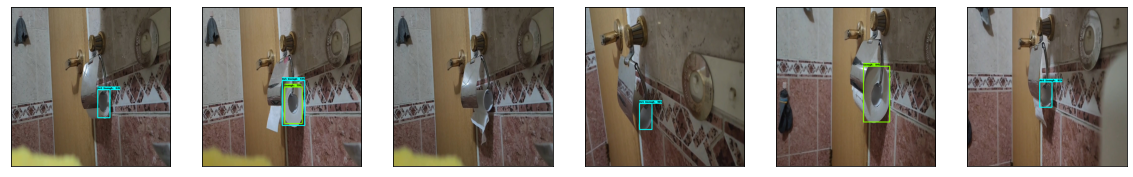

In [ ]:
if not os.path.isdir('results') :
  os.makedirs('results')

%matplotlib inline
fig = plt.figure(figsize=(20,5))

label_id_offset = 1

# 테스트 데이터에 대한 로더/추론/시각화가 포함된 코드입니다.
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  # 검출 결과가 시각화된 영상은 results 폴더 안에 저장됩니다.
  # 더 큰 화면으로 보고 싶으신 분들은 results 폴더 안을 살펴보세요:)
  result = plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name=os.path.join("results", "results_" + ('%02d' % i) + ".jpg"))

  ax = fig.add_subplot(1, len(test_images_np), i + 1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(result))

### 모델 저장
- 모델이 학습이 됐다면 이젠 저장하는 코드를 살펴보겠습니다.

- 모델의 저장 방식으론 크게 weight만을 저장하는 방식과 serving을 목적으로 모델 weight + framework을 전체 저장하는 방식으로 나뉩니다.

- Jetson Nano에서 실습을 진행하기 위해서는 serving을 목적으로 한 방식으로 모델을 저장해야 하지만, Colab과 Jetson Nano의 tensorflow 버전 이슈로 인해, 해당 실습에서 학습시킨 모델은 weight만을 따로 저장해서 새로운 colab 노트북에서 모델을 새로 저장합니다.

In [ ]:
fine_tune_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _prediction_heads=detection_model._box_predictor._prediction_heads,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fine_tune_model)
ckpt.write("./SSD_mobilenetV2_ckpt/ckpt-0") #weight를 저장

#저장한 weight는 아래 명령어를 통해 압축하여 local로 다운받습니다.
!cp -r /content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/checkpoint ./SSD_mobilenetV2_ckpt
! tar cvf /content/ckpt.tar /content/SSD_mobilenetV2_ckpt

from google.colab import files
files.download('ckpt.tar') 

tar: Removing leading `/' from member names
/content/SSD_mobilenetV2_ckpt/
/content/SSD_mobilenetV2_ckpt/ckpt-0.index
/content/SSD_mobilenetV2_ckpt/checkpoint
/content/SSD_mobilenetV2_ckpt/ckpt-0.data-00000-of-00001


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>